In [1]:
# https://person-dukcapil.vercel.app/api/data?nik=3174061410920006

# Enrichment Data
Prosess:
- Validation: Periksa apakah data seperti NIK (Nomor Induk Kependudukan) valid
- Request to Dukcapil: Menggunakan API Dukcapil untuk mencari data berdasarkan NIK.
- Transformation:  Ubah data hasil request API Dukcapil menjadi format yang sesuai
- Load: Menyimpan data yang sudah divalidasi dan ditransformasi ke dalam database

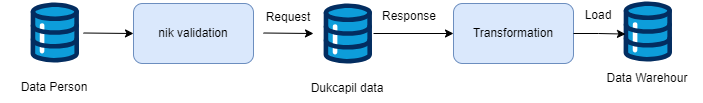

## Validation Prosess

Proses ini melakukan validasi struktur nik dari raw data.

Kelas Validation memvalidasi format NIK sebelum dikirim ke API Dukcapil. Mendukung validasi data dari sumber SPPTTI dan DPO.

Metode:
- validate_nik_spptti(): Memvalidasi format NIK dari data SPPTTI.
- validate_nik_dpo(): Memvalidasi format NIK dari data DPO.
- validate_person(): Menentukan sumber data (SPPTTI atau DPO) dan mengembalikan NIK jika valid.

In [2]:
import json

class Validation:
    """ 
    Validation is a class to validate data before sending to Dukcapil API

    Attributes:
    -----------
    data : dict
        Data to be validated
    
    Methods:
    --------
    validate_nik_spptti() -> str
        Validate NIK from SPPTTI data
    validate_nik_dpo() -> str
        Validate NIK from DPO data
    validate_person() -> str
        Validate NIK from SPPTTI or DPO data to be sent to Dukcapil API

    """
    def __init__(self, data):
        # convert to json
        self.data = json.loads(data)

    def validate_nik_spptti(self):
        # validate nik format
        nik = self.data.get('national_id')

        # Check if the NIK has exactly 16 digits
        if len(nik) == 16:
            return nik
        
    def validate_nik_dpo(self):
        # validate nik format
        jenis_identitas = self.data.get('jenis_identitas')

        if jenis_identitas == 'KTP':
            nik = self.data.get('nomor_identitas')

            # Check if the NIK has exactly 16 digits
            if len(nik) == 16:
                return nik


    def validate_person(self):
        # check if data is not empty
        if self.data:
            if self.data.get('source') == 'spptti':
                self.nik = self.validate_nik_spptti()
                return self.nik
            elif self.data.get('source') == 'dpo':
                self.nik = self.validate_nik_dpo()
                return self.nik

## Request Process

Kelas `DukcapilPerson` digunakan untuk mengirim permintaan ke API Dukcapil dan mengambil data seseorang berdasarkan NIK.

### Metode
- **`_request(path: str)`**: Mengirim permintaan GET ke API dan mengembalikan respons dalam format JSON.
- **`search_nik(nik: str)`**: Menggabungkan NIK ke endpoint API dan memanggil metode `_request` untuk mengambil data orang berdasarkan NIK.


In [3]:
import os
import requests


class DukcapilPerson:
    """
    DukcapilPerson is a class to get data from Dukcapil API

    Attributes:
    -----------
    dukcapil_url : str
        Dukcapil API URL
    
    Methods:
    --------
    _request(path : str) -> requests
        Send request to Dukcapil API
    search_nik(nik : str) -> requests
        Get data from Dukcapil API by NIK
    """
    def __init__(self,):
        self.dukcapil_url = os.getenv('DUKCAPIL_URL')

    def _request(
            self,
            path : str
        ) -> requests:
        response = requests.get(path)
        return response.json()
    
    def search_nik(self, nik):
        path = '/api/data?nik=' + nik
        return self._request(path = self.dukcapil_url + path)

## Transform Proces

Kelas Transform mengambil data yang dikembalikan oleh API Dukcapil dan mengonversinya ke format yang diperlukan untuk SPPTTI atau DPO.

Metode
- transform_data(): Mengembalikan kamus dengan detail orang yang siap untuk dimasukkan ke sistem SPPTTI atau DPO.

In [4]:
class Transform:
    """
    Transform is a class to transform data from Dukcapil API to be sent to SPPTTI or DPO API

    Attributes:
    -----------
    dukcapil_data : dict
        Data from Dukcapil API
    
    Methods:
    --------
    transform_data() -> dict
        Transform data from Dukcapil API to be sent to SPPTTI or DPO API
        
    """
    def __init__(self, dukcapil_data):
        self.dukcapil_data = dukcapil_data

    def transform_data(self):
        return {
            'jenis_identitas': 'KTP',
            'nomor_identitas': self.dukcapil_data['nik'],
            'nama_lengkap': self.dukcapil_data['nama'],
            'tanggal_lahir': self.dukcapil_data['tanggal_lahir'],
            'tempat_lahir': self.dukcapil_data['tempat_lahir'],
            'jenis_kelamin': self.dukcapil_data['jenis_kelamin'],
            'alamat': self.dukcapil_data['alamat'],
            'rt': self.dukcapil_data['rt'],
            'rw': self.dukcapil_data['rw'],
            'kelurahan': self.dukcapil_data['kelurahan'],
            'kecamatan': self.dukcapil_data['kecamatan'],
            'kabupaten_kota': self.dukcapil_data['kota'],
            'provinsi': self.dukcapil_data['provinsi'],
            'agama': self.dukcapil_data['agama'],
            'pekerjaan': self.dukcapil_data['pekerjaan'],
            'kewarganegaraan': self.dukcapil_data['kewarganegaraan'],
            'is_validate': True
        }

## Load Process

- Membuat Funsgi untuk memuat data ke dalam tabel PostgreSQL sebagai row baru dengan kondisi ```is_validate = True```.

In [11]:
from sqlalchemy import create_engine
import pandas as pd
from dotenv import load_dotenv
import os

load_dotenv(".env")
def load_data_to_postgres(data: pd.DataFrame, table_name: str):
    """
    Load data into a PostgreSQL database using SQLAlchemy.

    Parameters:
    -----------
    data : pd.DataFrame
        The data to be loaded into the database.
    
    table_name : str
        The name of the table where data should be inserted.

    Returns:
    --------
    None
    """
    DB_HOST = os.getenv('DB_HOST')
    DB_PORT = os.getenv('DB_PORT')
    DB_NAME = os.getenv('DB_NAME')
    DB_USER = os.getenv('DB_USER')
    DB_PASSWORD = os.getenv('DB_PASS')
    db_url = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    try:
        # Create the SQLAlchemy engine
        engine = create_engine(db_url)

        # Load data into PostgreSQL
        data.to_sql(table_name, engine, if_exists='append', index=False)

        print(f"Data successfully loaded into the '{table_name}' table.")
        
    except Exception as e:
        print(f"Error loading data: {e}")

    finally:
        # Dispose of the engine connection after use
        engine.dispose()


def extract_data(table_name):
    """
    Extract data from a PostgreSQL database using SQLAlchemy.

    Parameters:
    -----------
    table_name : str
        The name of the table to extract data from.

    Returns:
    --------
    data : pd.DataFrame
        The data extracted from the database. 
    """
    DB_HOST = os.getenv('DB_HOST')
    DB_PORT = os.getenv('DB_PORT')
    DB_NAME = os.getenv('DB_NAME')
    DB_USER = os.getenv('DB_USER')
    DB_PASSWORD = os.getenv('DB_PASS')
    db_url = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
    try:
        # Create the SQLAlchemy engine
        engine = create_engine(db_url)

        # Load data into PostgreSQL
        data = pd.read_sql(f"SELECT * FROM {table_name} WHERE is_validate = True", engine)

        return data
        
    except Exception as e:
        print(f"Error loading data: {e}")

    finally:
        # Dispose of the engine connection after use
        engine.dispose()

In [12]:
import pandas as pd


# Do Enrichment process
dukcapil = DukcapilPerson()

# read data from spppti.json
with open('spptti.json') as f:
    data = f.read()
validate = Validation(data)
nik = validate.validate_person()
if nik:
    dukcapil_data = dukcapil.search_nik(nik)
    if dukcapil_data.get('message') == 'Person not found':
        print('NIK not found in Dukcapil')
    else:
        transform = Transform(dukcapil_data)
        data = transform.transform_data()
        load_data_to_postgres(pd.DataFrame([data]), 'person')

Data successfully loaded into the 'person' table.


In [13]:
# Validate Dukcapil Only when the NIK is not validate in table person
df_person = extract_data('person')

dukcapil = DukcapilPerson()

# read data from spppti.json
with open('spptti.json') as f:
    data = f.read()

validate = Validation(data)
nik = validate.validate_person()

# if nik is not in df_person
if nik not in df_person['nomor_identitas'].values and nik:
    dukcapil_data = dukcapil.search_nik(nik)
    if dukcapil_data.get('message') == 'Person not found':
        print('NIK not found in Dukcapil')
    else:
        transform = Transform(dukcapil_data)
        data = transform.transform_data()
        load_data_to_postgres(pd.DataFrame([data]), 'person')